In [2]:
import logging
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
import tensorflow.keras.layers as kl
import tensorflow.keras.losses as kls
import tensorflow.keras.optimizers as ko
from pathlib import Path
import ruamel.yaml as yaml
from tqdm.notebook import tqdm
from tqdm.keras import TqdmCallback
import scipy.stats as stats
import sklearn.manifold
import sklearn.decomposition
import pickle

import ipywidgets as widgets
from IPython.display import display

%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
plt.style.use('ggplot')

get_ipython().run_line_magic('matplotlib', 'inline')

print("TensorFlow Ver: ", tf.__version__)

TensorFlow Ver:  2.3.0


In [3]:
seed = 1234
tf.random.set_seed(seed)
np.random.seed(seed)

In [4]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [5]:
# Eager by default!
print("Eager Execution:", tf.executing_eagerly())
print("1 + 2 + 3 + 4 + 5 =", tf.reduce_sum([1, 2, 3, 4, 5]))

Eager Execution: True
1 + 2 + 3 + 4 + 5 = tf.Tensor(15, shape=(), dtype=int32)


In [6]:
#Helper functions

probs_to_logits = lambda p: np.log(p/(1-p))

def get_largest_args(array, n):
    if n:
        contributor = np.argmax(array)
        array[contributor] = -10000.
        contributors = [contributor]
        contributors.extend(get_largest_args(array, n-1))
        return contributors
    else:
        return []

In [7]:
class dist_env():

    def __init__(self, n_timesteps=1000, keep_record=True):
        self.keep_record = keep_record
        self.n_timesteps = n_timesteps
        self.n_states = 4
        self.M_weighting_off_diagonal = 0.1
        self.wait_reward = -0.1
        self.wrong_reward = -1.
        self.right_reward = +1.
        self.observation_sigma = 1.
        self.reset()

    def reset(self, ):
        self.reset_M_random()
        self.done = False
        self.t = 0
        reward = self.wait_reward
        self.state = np.random.randint(0, self.n_states)
        observation = self.compute_observation(self.state)
        
        self._s_hist = np.array([self.state])
        self._r_hist = np.array([])
        self._o_hist = np.array([observation])
        
        return observation, reward, self.done, self.t        

    def reset_M_random(self, ):
        M = np.identity(self.n_states)
        M += self.M_weighting_off_diagonal*np.random.lognormal(size=M.shape)
        M /=np.sum(M, axis=1, keepdims=True)
        self.M = M
        M_trans = np.copy(M)
        M_trans[np.identity(self.n_states, dtype='bool')] = 0
        M_trans /=np.sum(M_trans, axis=1, keepdims=True)
        self.M_transition = M_trans

    def step(self, action):
        assert not self.done
        state = self.state
        reward = self.comp_reward(action, state)
        new_state = self.comp_transition(action, state)
        observation = self.compute_observation(new_state)
        
        self.t += 1
        if self.t >= self.n_timesteps:
            self.done = True
        self.state = new_state
        
        if self.keep_record:
            self._r_hist = np.append(self._r_hist, reward)
            self._s_hist = np.append(self._s_hist, new_state)
            self._o_hist = np.append(self._o_hist, observation)
            
        return observation, reward, self.done, self.t

    def comp_reward(self, action, state):
        if action == self.n_states:
            reward = self.wait_reward
        elif action == state:
            reward = self.right_reward
        else:
            reward = self.wrong_reward
                    
        return reward

    def comp_transition(self, action, state):
        if action == self.n_states:
            new_state = np.random.choice(self.n_states, p=self.M[state,:])
        else:
            new_state = np.random.choice(self.n_states, p=self.M_transition[state,:])
        return new_state
        
    def compute_observation(self, state):
        observation = stats.norm.rvs(loc=state, scale=self.observation_sigma)
        return observation

In [8]:
class Model(tf.keras.Model):
    def __init__(self, num_actions, batch_size=1, n_timesteps=None, n_features=8, name='meta_policy'):
        super().__init__(name)
#         Having a stateful LSTM means that you will need to reset the hidden state 
#         in between batches yourself if you do want independent batches. 
#         The default initial hidden state in Tensorflow is all zeros.
        self.lstm = kl.LSTM(
            48, name='hidden', 
            stateful=True, 
            time_major=True, # ['time', 'batch', 'features']
            return_sequences=True, 
            recurrent_initializer='zeros'
        )
        self.lstm.build((n_timesteps, batch_size, n_features)) # set batch size, must be done with stateful lstm
#         self.noise = kl.GaussianNoise(0.1)
        self.policy = kl.Dense(
            num_actions, name='policy'
        )
        self.value = kl.Dense(
            1, name='value'
        )

    def call(self, inputs, **kwargs):
        output = self.lstm(inputs)
        value = self.value(output)
        policy = self.policy(output)
#         noise = self.noise(output, training=True)
#         policy = self.policy(noise)
        return tf.squeeze(policy, 1), tf.squeeze(value, (1, 2))

    def predict_action_value(self, obs):
        # Executes `call()` under the hood.
        policy, value = self.predict_on_batch(obs)
        self.policy_values = policy
        actions = tf.squeeze(tf.random.categorical(policy, 1), 1)
        return actions, value

In [9]:
class Agent:
    def __init__(self, model, env, learning_rate=1e-3, gamma=0.8, value_coefficient=0.2, entropy_coefficient=.002, name='a2c_agent_alex', data_path=None):
        # `gamma` is the discount factor; coefficients are used for the loss terms.
        self.gamma = gamma
        self.value_coefficient = value_coefficient
        self.learning_rate = learning_rate
        self.entropy_coefficient = entropy_coefficient
        self.env =  env
        self.name = name
        self.model = model(env.n_states + 1, batch_size=1, name=self.name)
        self.states = np.arange(0, self.env.n_states, dtype=float)
        # Define separate losses for policy logits and value estimate.
        self.data_path = data_path or Path().cwd() / self.name
        self.parameters = {
            'learning_rate': learning_rate,
            'value_coefficient': value_coefficient,
            'entropy_coefficient': entropy_coefficient,
            'gamma': gamma 
        }
        self._compile()
    
    def save_agent(self):
        self.data_path.mkdir(parents=True, exist_ok=True)
        logging.info(f"Saving parameters, training_history and weights to {self.data_path}.")
        with open(str(self.data_path / self.name) + '.yaml', 'w') as f:
            yaml.dump(self.parameters, f)
        np.save(str(self.data_path / self.name) + 'training.npy', self.training_history)
        np.save(str(self.data_path / self.name) + 'testing.npy', self.testing_history)
        self.model.save_weights(str(self.data_path / self.name))
        if "self.lstm_to_policy_model" in locals():
            self.lstm_to_policy_model.save_weights(str(self.data_path / self.name) + "_policy")
        else:
            self._fit_lstm_to_policy()
            self.lstm_to_policy_model.save_weights(str(self.data_path / self.name) + "_policy")
        
        if "self.lstm_to_value_model" in locals():
            self.lstm_to_value_model.save_weights(str(self.data_path / self.name) + "_value")
        else:
            self._fit_lstm_to_value()
            self.lstm_to_value_model.save_weights(str(self.data_path / self.name) + "_value")
        
    def load_agent(self):
        print('Loading agent...')
        logging.warning("Updating parameters, training_history, weights and recompiling model.")
        with open(str(self.data_path / self.name) + '.yaml', 'r') as f:
            self.parameters = yaml.load(f, Loader=yaml.Loader)
        print('Parameters loaded')
        self.training_history = np.load(str(self.data_path / self.name) + 'training.npy')
        print('Training history loaded')
        self.testing_history = np.load(str(self.data_path / self.name) + 'testing.npy', allow_pickle=True).item()
        print('Testing history loaded')
        self.model.load_weights(str(self.data_path / self.name))
        
        self._fit_lstm_to_policy(fit=False) #Make model
        self.lstm_to_policy_model.load_weights(str(self.data_path / self.name) + "_policy")
        self._fit_lstm_to_value(fit=False)
        self.lstm_to_value_model.load_weights(str(self.data_path / self.name) + "_value")
        print('Weights loaded')
        self.__dict__.update(self.parameters)
        print('Parameters updated')
        self._compile()
        print('Compiled')
        
    def _compile(self):
        self.model.compile(
            optimizer=ko.Adam(lr=self.learning_rate), 
            loss=[self._policy_loss, self._value_loss])
    
    def _predict(self, action, state_observation, reward, timestep):
        action = np.squeeze(action)
        action = tf.one_hot(action, self.env.n_states + 1)
        single_input = np.concatenate([
            [[state_observation]],
            [[reward]],
            [action],
            [[timestep]]], 1)
        single_input = tf.cast(single_input, dtype=tf.float32)
        single_input = tf.expand_dims(single_input, [1])
        new_action, value = self.model.predict_action_value(single_input)
        return new_action, value, single_input

    def train(self, episodes=250):
        # Training loop: collect samples, send to optimizer, repeat episodes times.
        self.testing_history = { # Reset testing history
            'actions': [],
            'observations': [],
            'rewards': [],
            'beliefs': [],
            'lstm_values': [],
            'policies': [],
            'values': []
        }
        self.flat_testing_history = {}
        
        self.training_history = []
        for episode in tqdm(range(episodes)):
            actions, observations, rewards, values, inputs = self.run_episode()
            self.training_history.append(np.sum(rewards))

            logging.info(f"Episode: {len(self.training_history) - 1:3d}, Reward: {int(self.training_history[-1]):3d}")
            
            # `next_value` is the bootstrap value estimate of the future state (critic).
            _, next_value, _ = self._predict(actions[-1], observations[-1], rewards[-1], inputs[-1,0,3] + 1)

            self.model.reset_states()
            
            returns, advantages = self._returns_advantages(rewards, values, next_value)
            # A trick to input actions and advantages through same API.
            actions_advantages = np.concatenate([actions[:, None], advantages[:, None]], axis=1)
            
            losses = self.model.train_on_batch(inputs, [actions_advantages, returns])
            
            logging.debug(f"[{episode + 1:d}/{episodes:d}] Losses: {losses}")
        return self.training_history

    def run_episode(self):
        state_observation, reward, done, timestep = self.env.reset()

        action = 4 # I don't know
        # Storage helpers for a single batch of data.
        actions = np.empty(self.env.n_timesteps, dtype=np.int32)
        rewards, values, observations = np.empty((3, self.env.n_timesteps))
        inputs = np.empty((self.env.n_timesteps, 1, 8))
        
        self.model.reset_states()
        step = 0
        while not done:
            # action and reward at t - 1 and timestep at t
            action, value, inputs[step] = self._predict(action, state_observation, reward, timestep + 1)
            state_observation, reward, done, timestep = self.env.step(action)
            # rewards, values and actions at t
            observations[step] = state_observation
            rewards[step] = reward
            actions[step] = action
            values[step] = value
            step += 1
        return actions, observations, rewards, values, inputs
    
    def _returns_advantages(self, rewards, values, next_value):
        # `next_value` is the bootstrap value estimate of the future state (critic).
        returns = np.append(np.zeros_like(rewards), next_value, axis=-1)
        # Returns are calculated as discounted sum of future rewards.
        for t in reversed(range(rewards.shape[0])):
            returns[t] = rewards[t] + self.gamma * returns[t + 1]
        returns = returns[:-1]
        # Advantages are equal to returns - baseline (value estimates in our case).
        advantages = returns - values
        return returns, advantages

    def _value_loss(self, returns, value):
        # Value loss is typically MSE between value estimates and returns.
        loss = self.value_coefficient * kls.mean_squared_error(returns, value)
#         tf.keras.backend.print_tensor(loss)
        return loss

    def _policy_loss(self, actions_and_advantages, logits):
        # A trick to input actions and advantages through the same API.
        actions, advantages = tf.split(actions_and_advantages, 2, axis=-1)
        # Sparse categorical CE loss obj that supports sample_weight arg on `call()`.
        # `from_logits` argument ensures transformation into normalized probabilities.
        weighted_sparse_ce = kls.SparseCategoricalCrossentropy(from_logits=True)
        # Policy loss is defined by policy gradients, weighted by advantages.
        # Note: we only calculate the loss on the actions we've actually taken.
        actions = tf.cast(actions, tf.int32)
        policy_loss = weighted_sparse_ce(actions, logits, sample_weight=advantages)
        # Entropy loss can be calculated as cross-entropy over itself.
        probs = tf.nn.softmax(logits)
        entropy_loss = tf.reduce_sum(kls.categorical_crossentropy(probs, probs))
        # We want to minimize policy and maximize entropy losses.
        # Here signs are flipped because the optimizer minimizes.
#         tf.keras.backend.print_tensor(policy_loss)
#         tf.keras.backend.print_tensor(entropy_loss)
        loss = policy_loss - self.entropy_coefficient * entropy_loss
        return loss
    
    def test(self, episodes=100):
        if "self.testing_history" not in locals():
            print('Train agent before testing it')
            return False
        
        # Testing loop: collect samples, repeat episodes times.
        action_list = self.testing_history['actions']
        observations_list = self.testing_history['observations']
        rewards_list = self.testing_history['rewards']
        beliefs_list = self.testing_history['beliefs']
        lstm_values_list = self.testing_history['lstm_values']
        policies_list = self.testing_history['policies']
        values_list= self.testing_history['values']

        for episode in tqdm(range(episodes)):
            actions, observations, rewards, values, inputs, beliefs, lstm_values, policies = self.run_test_episode()
            
            action_list.append(actions)
            observations_list.append(observations)
            rewards_list.append(rewards)
            beliefs_list.append(beliefs)
            lstm_values_list.append(lstm_values)
            policies_list.append(policies)
            values_list.append(values)
            
            # `next_value` is the bootstrap value estimate of the future state (critic).
            _, next_value, _ = self._predict(actions[-1], observations[-1], rewards[-1], inputs[-1,0,3] + 1)

            self.model.reset_states()
            
            returns, advantages = self._returns_advantages(rewards, values, next_value)
            # A trick to input actions and advantages through same API.
            actions_advantages = np.concatenate([actions[:, None], advantages[:, None]], axis=1)
            
            losses = self.model.test_on_batch(inputs, [actions_advantages, returns])
            
            logging.debug(f"[{episode + 1:d}/{episodes:d}] Losses: {losses}")
        
        self.testing_history = {
            'actions': action_list,
            'observations': observations_list,
            'rewards': rewards_list,
            'beliefs': beliefs_list,
            'lstm_values': lstm_values_list,
            'policies': policies_list,
            'values': values_list
        }
            
        return self.testing_history
    
    def run_test_episode(self):
        state_observation, reward, done, timestep = self.env.reset()

        action = 4 # I don't know
        # Storage helpers for a single batch of data.
        actions = np.empty(self.env.n_timesteps, dtype=np.int32)
        actions[-1] = 4
        rewards, values, observations = np.empty((3, self.env.n_timesteps))
        inputs = np.empty((self.env.n_timesteps, 1, 8))
        beliefs = np.empty((self.env.n_states, self.env.n_timesteps))
        beliefs[:,-1] = np.zeros(self.env.n_states)
        lstm_values = np.empty((48, self.env.n_timesteps))
        policies = np.empty((self.env.n_states + 1, self.env.n_timesteps))
        
        self.model.reset_states()
        step = 0
        while not done:
            # action and reward at t - 1 and timestep at t
            action, value, inputs[step] = self._predict(action, state_observation, reward, timestep + 1)
            state_observation, reward, done, timestep = self.env.step(action)
            # rewards, values and actions at t
            observations[step] = state_observation
            rewards[step] = reward
            actions[step] = action
            values[step] = value
            beliefs[:,step] = self._belief_estimate(beliefs[:,step-1], state_observation, actions[step], reward)
            lstm_values[:,step] = self.model.lstm.states[0].numpy()
            policies[:,step] = self.model.policy_values
            step += 1
        return actions, observations, rewards, values, inputs, beliefs, lstm_values, policies
    
    def _belief_estimate(self, prev_bel, observation, action, reward, new_weight=1.5):        
        prev_belief = np.copy(prev_bel) # To prevent side effects
        prev_belief[[tuple(action == self.states)]] = 0.
        just_switched_from = np.where(reward == self.env.right_reward, action, np.argmax(prev_belief))
        
        more_info = new_weight * stats.norm.pdf(observation, loc=self.states)
        new_info = np.copy(more_info)
        new_info[just_switched_from] = 0.0001
        
        belief = np.where(
            reward == self.env.wait_reward,
            prev_belief + more_info, 
            new_info
        )
        
        belief = belief / np.sum(belief)
        
        return belief
    
    def _testing_history_print(self, episode_list=[0], full_history=False):
        #Prints the testing history from an episode        
        
        emp_thresh = []
        episode_lens = [len(self.testing_history['actions'][episode]) for episode in episode_list]
        tot_len = sum(episode_lens)
        total_iter = 0
        res = np.zeros((self.env.n_states+1, 3, tot_len))
        correctly_classified = 0
        #[action][Wrong action, right action, diff between two highest probs][iteration]
        
        if full_history:
            print("                |-----------belief---------|------------policy output-----------|")
            print("act| rew  | obs |    0     1     2     3   |     0      1      2      3      4")
            
        for episode in episode_list:
            if full_history:
                print("---")
            for i in range(episode_lens[episode]-1):
                
                act = self.testing_history['actions'][episode][i]
                obs = self.testing_history['observations'][episode][i]
                rew = self.testing_history['rewards'][episode][i]
                bel = probs_to_logits(self.testing_history['beliefs'][episode][:,i])
                prev_bel = self.testing_history['beliefs'][episode][:,i-1]
                pol = self.testing_history['policies'][episode][:,i+1]

                two_largest = prev_bel[np.argpartition(prev_bel, -2)]
                if act != np.argmax(prev_bel) and act != 4:
                    pre, post = "\x1b[31m", "\x1b[0m" # Colour errors red
                    res[act,0,total_iter] += 1
                    res[act,2,total_iter] = np.absolute(two_largest[-1] - two_largest[-2])

                elif act == 4:
                    pre, post = "\x1b[93m", "\x1b[0m" # Colour waits yellow
                    if i != 0:
                        emp_thresh.append(np.absolute(two_largest[-1] - two_largest[-2]))
                else:
                    pre, post = "", ""
                    res[act,1,total_iter] += 1
                    res[act,2,total_iter] = np.absolute(two_largest[-1] - two_largest[-2])
                
                correctly_classified += np.where(np.argmax(bel) == np.argmax(pol), 1, 0)
                
                if full_history:
                    print(f"{pre} {act} |  {rew:4}|{obs:5.2f}|"
                          f" {bel[0]:6.3f}{bel[1]:6.3f}{bel[2]:6.3f}{bel[3]:6.3f} |"
                          f" {pol[0]:7.3f}{pol[1]:7.3f}{pol[2]:7.3f}{pol[3]:7.3f}{pol[4]:7.3f}{post}"
                         )
                
                total_iter += 1
        emp_thresh = np.array(emp_thresh)
        threshold_mean = np.mean(emp_thresh)
    
        print(f"Threshold for waiting is estimated to be {threshold_mean:.4%} with standard deviation {stats.sem(emp_thresh):.4%}")
        print("This table shows how setting a hard threshold affects how many of "
              "the actual waiting actions are picked up, and how big portion of those previously "
              "classified (either correctly and wrongly) to an action other "
              "than waiting are then misclassified as waiting.\n" 
              "The first part gives how many of the non-waiting actions were correctly predicted.\n"
             )
        
        print("                |---initially correctly classified actions (with no waiting)----|")
        print("                |       0       |       1       |       2       |       3       |")
        
        string_to_print = "                |"
        for n in range(4):
            string_to_print += (f"{(np.sum(res[n,1,:])/np.sum(res[n,:2,:])):10.1%}     |")
        print(string_to_print)
        
        print(" coeff | thresh |----wrongly classed as waiting (prev classed correct/wrong)----|wrongly classed as not waiting")
        print("----------------------------------------------------------------------------------------------------------------")
        for coeff in np.linspace(0,1.5,16):
            thresh = coeff * threshold_mean
            still_not_waiting = emp_thresh[emp_thresh > thresh]
            
            string_to_print = f"{coeff:6.1%} | {thresh:6.2%} |"
            for n in range(4):
                string_to_print += (f"{(np.sum(res[n,1,res[n,2,:]<thresh])/np.sum(res[n,:2,:])):7.1%}/"
                                    f"{(np.sum(res[n,0,res[n,2,:]<thresh])/np.sum(res[n,:2,:])):6.1%} |")
            string_to_print += f"{(still_not_waiting.size/tot_len):15.1%}"
            
            print(string_to_print)
        
        print(f"\nAll in all, {((np.sum(res[:,1,:]))/(np.sum(res[:,:2,:])+emp_thresh.size)):.1%} were classified correctly.")
        print(f"Another way to see it is that {correctly_classified/((np.sum(res[:,:2,:])+emp_thresh.size))} were correctly classified.")
    
    def _get_flat_testing_history(self, kind):
        episodic_data = self.testing_history[kind]
        episodic_data_shape = np.shape(episodic_data)
        
        if "self.flat_testing_history" in locals():
            if kind in self.flat_testing_history:
                return self.flat_testing_history[kind]
        else:
            self.flat_testing_history = {}
        
        if kind == 'policies' or kind == 'beliefs':
            episodes = episodic_data_shape[0]
            states = episodic_data_shape[1]
            episode_length = episodic_data_shape[2]
        
            flat_testing_history = np.empty((states, episodes * episode_length))
            for episode, episode_data in enumerate(episodic_data):
                flat_testing_history[:,episode*episode_length:(episode+1)*episode_length] = episode_data
            
            self.flat_testing_history[kind] = flat_testing_history.T
        elif kind == 'lstm_values':
            episodes = episodic_data_shape[0]
            neurons = episodic_data_shape[1]
            episode_length = episodic_data_shape[2]
        
            flat_testing_history = np.empty((neurons, episodes * episode_length))
            for episode, episode_data in enumerate(episodic_data):
                flat_testing_history[:,episode*episode_length:(episode+1)*episode_length] = episode_data
            
            self.flat_testing_history[kind] = flat_testing_history.T
        elif kind == 'actions' or kind == 'values' or kind == 'actions' or kind == 'rewards' or kind == 'observations':
            episodes = episodic_data_shape[0]
            episode_length = episodic_data_shape[1]
        
            flat_testing_history = np.empty(episodes * episode_length)
            for episode, episode_data in enumerate(episodic_data):
                flat_testing_history[episode*episode_length:(episode+1)*episode_length] = episode_data

            self.flat_testing_history[kind] = flat_testing_history.T
        
        return self.flat_testing_history[kind]
    
    def _analyse_LSTM(self, action_contributors=True, neuron_contributors=True):
        #Analyse the weights, biases, and action conditional average values
        #from the LSTM layer into the four state actions and the wait action
        
        actions = self._get_flat_testing_history('actions').astype('int32')
        lstm_values = self._get_flat_testing_history('lstm_values')
        policy_weights = self.model.policy.get_weights()[0]
        policy_biases = self.model.policy.get_weights()[1]
        policy_values = self._get_flat_testing_history('policies')
        
        # lstm_weights = self.model.lstm.get_weights()[0][:,48*3:]
        # lstm_biases = self.model.lstm.get_weights()[2][48*3:]

        lstm_impact_data = np.zeros((lstm_values.shape[1], actions.shape[0], policy_weights.shape[1]))
        for i, action in enumerate(actions):
            for n, lstm_neuron in enumerate(lstm_values[i,:]):
                lstm_impact_data[n, action, :] += np.dot(lstm_neuron, policy_weights[n,:])
        
        lstm_impact_data = lstm_impact_data/actions.size
        
        lstm_impact = np.zeros((lstm_values.shape[1], env.n_states + 1))
        for action in range(env.n_states + 1):
            for other_action in range(env.n_states + 1):
                if action == other_action:
                    lstm_impact[:, action] += lstm_impact_data[:,action,action]
                else:
                    lstm_impact[:, action] -= lstm_impact_data[:,action,action]/(env.n_states + 1)
        
        if action_contributors:
            print("    |-----------------------------Contributing most positively/negatively---------------------------|")
            print("act |           |           |           |           |           |           |           |           |")

            for action in range(env.n_states + 1):
                impact_copy = np.copy(lstm_impact)
                biggest_arguments = np.array(get_largest_args(impact_copy[:,action], 8))
                string_to_print = f"{action:3d} |"
                for argument in biggest_arguments:
                    string_to_print += f"{argument:3d}, {lstm_impact[argument, action]:6.3f}|"
                string_to_print += "\n"

                impact_copy = -np.copy(lstm_impact)
                most_negative_arguments = np.array(get_largest_args(impact_copy[:,action], 8))
                string_to_print += "    |"
                for argument in reversed(most_negative_arguments):
                    string_to_print += f"{argument:3d}, {lstm_impact[argument, action]:6.3f}|"
                string_to_print += "\n                                         ---"  
                print(string_to_print)
        
        if neuron_contributors:
            print("      |---------------------Actions---------------------|")
            print("neuron|    0    |    1    |    2    |    3    | Waiting |")
            
            #sorted_impact = np.sort(lstm_impact.flatten)
            #upper_threshold, lower_threshold = sorted_impact[-6], sorted_impact[5]
            upper_threshold, lower_threshold = 0.01, -0.008
            
            for n in range(lstm_values.shape[1]):
                neuron_impact = lstm_impact[n,:]
                string_to_print = f" {n:2}   |"
                for action in range(env.n_states + 1):
                    if neuron_impact[action] > upper_threshold:
                        string_to_print += f"\x1b[34m{neuron_impact[action]:9.6f} \x1b[0m|"
                    elif neuron_impact[action] > 0:
                        string_to_print += f"\x1b[94m{neuron_impact[action]:9.6f} \x1b[0m|"
                    elif neuron_impact[action] < lower_threshold:
                        string_to_print += f"\x1b[31m{-neuron_impact[action]:9.6f} \x1b[0m|"
                    else:
                        string_to_print += f"\x1b[91m{-neuron_impact[action]:9.6f} \x1b[0m|"
                print(string_to_print)
        
        return lstm_impact
    
    def _fit_belief_estimate(self):
        beliefs = probs_to_logits(agent._get_flat_testing_history('beliefs'))
        actions = agent._get_flat_testing_history('actions')
        observations = agent._get_flat_testing_history('observations')
        rewards = agent._get_flat_testing_history('rewards')
        _input = np.empty((beliefs.shape[0] + 3, beliefs.shape[1]))
        _input[:beliefs.shape[0]+1] = beliefs
        _input[beliefs.shape[0]+1] = actions
        _input[beliefs.shape[0]+2] = observations
        _input[beliefs.shape[0]+3] = rewards
        label = self._get_flat_testing_history('policies')[:-1]
        states = env.n_states + 1

        model = Sequential()
        model.add(kl.Dense(states+8, input_dim=states+2, activation='elu'))
        model.add(kl.Dense(1, input_dim=states+8, activation='elu'))
        model.compile(loss='mean_squared_error', optimizer='adam', metrics=[tf.keras.metrics.MeanSquaredError()])

        model.fit(_input, label, epochs=1, batch_size=10, verbose=0, callbacks=[TqdmCallback(verbose=1)])
        _, mean_squared_error = model.evaluate(_input, label)
        print('Mean_squared_error: %.2f' % (mean_squared_error*100))

        for input_row, ground_truth in zip(_input[:,-10], label[-10]):
            pred = model.predict(input_row[np.newaxis,:])[0][0]
            diff = np.square(pred - ground_truth)
            print(f"Pred: {pred}. Ground: {ground_truth}. MSE: {diff}")
        
        self.belief_model = model
    
    def _fit_policy_to_lstm(self):
        _input = self._get_flat_testing_history('policies')
        label = self._get_flat_testing_history('lstm_values')

        model = Sequential()
        model.add(kl.Dense(8, input_dim=env.n_states+1))
        model.add(kl.Dense(48, input_dim=8))
        model.compile(loss='mean_squared_error', optimizer='adam')
        
        model.fit(_input, label, epochs=10, batch_size=100, verbose=0, callbacks=[TqdmCallback(verbose=1)])
        #_, mean_squared_error = model.evaluate(_input[950000:,:], label[950000:,:])
        #print('Mean_squared_error: %.2f' % (mean_squared_error*100))
        
        self.policy_to_lstm_model = model
    
    def _fit_lstm_to_policy(self, fit=True):
        model = Sequential()
        model.add(kl.Dense(env.n_states+1, input_dim=48))
        model.compile(loss='mean_squared_error', optimizer='adam')
        
        if fit:
            _input = self._get_flat_testing_history('lstm_values')
            label = self._get_flat_testing_history('policies')
            model.fit(_input, label, epochs=5, batch_size=100, verbose=0, callbacks=[TqdmCallback(verbose=1)])
        #_, mean_squared_error = model.evaluate(_input[950000:,:], label[950000:,:])
        #print('Mean_squared_error: %.2f' % (mean_squared_error*100))
        
        self.lstm_to_policy_model = model
    
    def _fit_lstm_to_value(self, fit=True):
        model = Sequential()
        model.add(kl.Dense(1, input_dim=48))
        model.compile(loss='mean_squared_error', optimizer='adam')
        
        if fit:
            _input = self._get_flat_testing_history('lstm_values')
            label = self._get_flat_testing_history('values')
            model.fit(_input, label, epochs=5, batch_size=100, verbose=0, callbacks=[TqdmCallback(verbose=1)])
        
        self.lstm_to_value_model = model
    
    def _fit_belief_to_lstm(self): #TODO: Filter out all belief values that don't have the same order as the policy
        _input = probs_to_logits(self._get_flat_testing_history('beliefs'))[:-1]
        policies = self._get_flat_testing_history('policies')[1:]
        label = self._get_flat_testing_history('lstm_values')[1:]
        mask = np.where(
            np.argmax(policies, axis=1) == env.n_states + 1,
            True,
            np.argmax(_input, axis=1) == np.argmax(policies, axis=1)
        )
        
        print(f"Made mask with {np.sum(mask)} of {mask.size} datapoints.")
        
        _input = _input[mask]
        label = label[mask]
        
        model = Sequential()
        model.add(kl.Dense(48, input_dim=env.n_states))
        model.compile(loss='mean_squared_error', optimizer='adam')
        
        training_history = model.fit(_input, label, epochs=10, batch_size=100, verbose=0, callbacks=[TqdmCallback(verbose=1)])
        print(training_history.history['loss'])
        plt.plot(training_history.history['loss'], label="Loss")
        plt.legend()
        plt.show()
        #_, mean_squared_error = model.evaluate(_input[950000:,:], label[950000:,:])
        #print('Mean_squared_error: %.2f' % (mean_squared_error*100))
        
        self.belief_to_lstm_model = model
    
    def _fit_belief_to_policy(self):
        _input = agent._get_flat_testing_history('beliefs')
        label = self._get_flat_testing_history('policies')
        print(_input.shape, label.shape)

        model = Sequential()
        model.add(kl.Dense(8, input_dim=env.n_states))
        model.add(kl.Dense(env.n_states+1, input_dim=8))
        model.compile(loss='mean_squared_error', optimizer='adam')
        
        model.fit(_input, label, epochs=100, batch_size=100, verbose=0, callbacks=[TqdmCallback(verbose=1)])
        #_, mean_squared_error = model.evaluate(_input[950000:,:], label[950000:,:])
        #print('Mean_squared_error: %.2f' % (mean_squared_error*100))
        
        self.belief_to_policy_model = model
    
    def _autoencode_lstm(self, reduced_dimensions=2, epochs=10, batch_size=100):
        lstm_values = agent._get_flat_testing_history('lstm_values')
        
        model = Sequential()
        model.add(kl.Dense(reduced_dimensions, input_dim=48))
        model.add(kl.Dense(48, input_dim=reduced_dimensions))
        model.compile(loss='mean_squared_error', optimizer='adam')
        
        training_history = model.fit(lstm_values, lstm_values, epochs=epochs, batch_size=batch_size, verbose=0, callbacks=[TqdmCallback(verbose=1)])
        #_, mean_squared_error = model.evaluate(_input[950000:,:], label[950000:,:])
        #print('Mean_squared_error: %.2f' % (mean_squared_error*100))
        
        self.lstm_autoencoder = model
    

In [10]:
logging.getLogger().setLevel(logging.WARNING)

env = dist_env(n_timesteps=100)
agent = Agent(Model, env)

In [25]:
#N = 80000
#training_history = agent.train(N)

In [11]:
agent.load_agent()

Loading agent...
Parameters loaded
Training history loaded
Testing history loaded
Weights loaded
Parameters updated
Compiled


In [13]:
#N = 50000
#testing_history = agent.test(N)

In [38]:
#agent.save_agent()

In [39]:
#agent._testing_history_print(list(range(3)), full_history=True)

                |-----------belief---------|------------policy output-----------|
act| rew  | obs |    0     1     2     3   |     0      1      2      3      4
---
 3 |  -1.0| 2.75| -9.361-2.069-0.449-0.008 |  -5.055 -1.274  0.432  3.148  1.226
 2 |   1.0| 0.45|  0.009-0.095-9.286-3.826 |   2.728  2.651 -4.165 -3.215  2.153
 1 |   1.0| 1.45| -1.204-9.109 0.280-1.389 |  -0.842 -3.710  2.988 -0.923  1.009
 2 |   1.0| 3.62| -6.389-3.236-8.547 3.185 |  -6.406 -0.552 -1.900  7.344  2.399
 3 |   1.0| 2.16| -2.742-0.756 0.489-9.162 |  -5.195 -0.147  5.061 -1.607  1.149
 2 |   1.0| 3.20| -5.190-2.409-8.769 2.336 |  -6.324 -1.560 -1.052  7.576  2.171
 3 |   1.0|-0.43|  0.793-0.985-3.191-8.978 |   5.517  0.358 -1.803 -7.756  2.887
 0 |   1.0| 1.29| -9.373-0.047-0.428-2.018 |  -3.475 -0.096  3.379 -1.238  0.963
 2 |   1.0| 3.11| -4.931-2.227-8.801 2.146 |  -5.589 -1.492 -1.032  6.862  2.040
 3 |   1.0| 1.67| -1.951-0.402-0.101-9.387 |  -3.841 -1.004  5.253 -2.101  1.038
 2 |  -1.0| 0.24|  1.426-

In [12]:
class LSTM_dataset:
    def __init__(self, lstm_values, policies, values, lstm_to_policies, lstm_to_values, low_dim_mappings = False, verbose=2, def_pca_components=23, def_data_size=10000, name='lstm'):
        self.name = name
        self.verbose = verbose
        self.lstm = lstm_values
        self.lstm_width = lstm_values.shape[1]
        self.values = values #Value estimate from agent
        
        if self.verbose > 0:
            print('Adding all low dimensional mappings')
        
        if low_dim_mappings:
            self.low_dim_mappings = low_dim_mappings
        else:
            self.low_dim_mappings = {}
        
        self.policies = policies
        states = np.arange(self.policies.shape[1]-1)
        policy_probs = np.exp(self.policies[:,:4])/(1+np.exp(self.policies[:,:4]))
        policy_probs = policy_probs/np.sum(policy_probs, axis=1)[:,np.newaxis]
        self.exp_pol = np.dot(policy_probs, states)
        self.confidence = 4 - self.policies[:,4]
        self.lstm_to_policies = lstm_to_policies
        self.lstm_to_values = lstm_to_values
        
        self.data_path = Path().cwd() / 'lstm_datasets' / self.name
        
        if self.verbose > 0:
            print('Doing a PCA analysis')
        self.def_pca_components = def_pca_components
        self.def_data_size = def_data_size
        pca = sklearn.decomposition.PCA(n_components=def_pca_components)
        self.def_pca_dat = pca.fit_transform(self.lstm[:self.def_data_size,:])
        
        #Set colors
        N = 2048
        colors = [(1, 1, 1), (0, 0, 0)]
        colormap1 = LinearSegmentedColormap.from_list('bw', colors, N=N)

        colors = np.array([[117, 196, 139], [146, 196, 67], [183, 38, 61], [61, 62, 120]], dtype=float)
        colors *= 1.2/np.sum(colors, axis=1)[:,np.newaxis]
        colormap2 = LinearSegmentedColormap.from_list('gyrb', colors, N=N)
        
        xx, yy = np.mgrid[0:4:4/N,0:3:3/N]
        self.colorIm = self.colorFromBivariateData(xx, yy, N, cmap1=colormap1, cmap2=colormap2)
        self.color = self.colorFromBivariateData(self.confidence, self.exp_pol, N, cmap1=colormap1, cmap2=colormap2)
        
        if verbose > 0:
            print('Finding histogram limits')
        #Set histogram limits
        self.median = np.empty(self.lstm_width)
        self.hist_limits = np.empty((self.lstm_width, 2))
        for i in range(self.lstm_width):
            sorted_values = np.sort(self.lstm[:,i])
            self.hist_limits[i,0] = sorted_values[int(lstm_values.shape[0]*0.02)]
            self.hist_limits[i,1] = sorted_values[int(lstm_values.shape[0]*0.98)]
            self.median[i] = sorted_values[int(lstm_values.shape[0]*0.5)]

    def save_low_dim_mappings(self):
        self.data_path.mkdir(parents=True, exist_ok=True)
        mappings_to_save = {}
        for perplexity, mapping in self.low_dim_mappings.items():
            mappings_to_save[perplexity] = {}
            mappings_to_save[perplexity]['tsne_data'] = mapping.tsne_data
            mappings_to_save[perplexity]['metadata'] = mapping.metadata
        pickle.dump(mappings_to_save, open(str(self.data_path / self.name) + '_low_dim_mappings.npy', "wb" ))
        
    def load_low_dim_mappings(self):
        if self.verbose > 0:
            print('Loading low dimensional mappings...')
        mappings_to_load = pickle.load(open(str(self.data_path / self.name) + '_low_dim_mappings.npy', "rb" ))
        for perplexity, mapping in mappings_to_load.items():
            self.low_dim_mappings[perplexity] = Low_dim_mapping(
                mapping['tsne_data'],
                None,
                None,
                self,
                mapping['metadata']
            )
            
        
    def new_low_dim(self, perplexity, n_iter=4000, learning_rate=200):
        tsne = sklearn.manifold.TSNE(
            verbose=2,
            random_state=1,
            perplexity=perplexity,
            n_iter=n_iter,
            learning_rate = learning_rate
        )
        
        self.low_dim_mappings[perplexity] = Low_dim_mapping(
                tsne.fit_transform(self.def_pca_dat),
                None,
                None,
                self,
                {
                    'perplexity': perplexity,
                    'random_state': 1,
                    'n_iter': n_iter,
                    'learning_rate': learning_rate
                }
            )
        
    def colorFromBivariateData(self, Z1, Z2, N, cmap1, cmap2):    
        Z1_plot = np.array((N-1)*(Z1)/4, dtype=np.int)
        Z2_plot = np.array((N-1)*(Z2)/3, dtype=np.int)
        
        Z1_color = cmap1(Z1_plot)
        Z2_color = cmap2(Z2_plot)

        Z_color = np.sum([Z1_color, Z2_color], axis=0)/2.0
        return Z_color

In [13]:
lstm_values = agent._get_flat_testing_history('lstm_values')
#low_dim_values = tsne_models[4500].predict(all_lstm_values)
policies = agent._get_flat_testing_history('policies')
values = agent._get_flat_testing_history('values')
lstm_to_policies = agent.lstm_to_policy_model
#low_dim_mappings = lstm.low_dim_mappings
lstm_to_values = agent.lstm_to_policy_model

In [14]:
lstm = LSTM_dataset(lstm_values, policies, values, lstm_to_policies, lstm_to_values)
#lstm = LSTM_dataset(lstm_values, policies, values, lstm_to_policies, lstm_to_values, low_dim_mappings=low_dim_mappings)

Adding all low dimensional mappings
Doing a PCA analysis
Finding histogram limits


In [15]:
class Low_dim_mapping:
    def __init__(self, tsne_data, nn_model, nn_data, lstm_dataset, metadata, verbose=2):
        self.tsne_data = tsne_data
        self.metadata = metadata #{perplexity, iterations, random state, learning}
        self.clusters = []
        self.lstm = lstm_dataset
        self.data_size = self.tsne_data.shape[0]
        self.nn_model = nn_model
        self.nn_data = nn_data
        self.verbose = verbose
    
    def fit_nn(self, training_plot=False):
        model = Sequential()
        model.add(kl.Dense(2, input_dim=48))
        model.compile(loss='mean_squared_error', optimizer='adam')
        if self.verbose > 0:
            print(f"Fitting t-SNE data with perplexity {self.metadata['perplexity']}")
        training_data = model.fit(
            self.lstm.lstm[:self.data_size],
            self.tsne_data,
            epochs=50,
            batch_size=10,
            verbose=0,
            callbacks=[TqdmCallback(verbose=1)]
        )
        if training_plot:
            plt.plot(training_data.history['loss'], label="Loss")
            plt.legend()
            plt.show()

        self.nn_model = model
        if self.verbose > 0:
            print("Predicting on all LSTM data")
        self.nn_data = model.predict(self.lstm.lstm)
    
    def populate_nn_data(self):
        self.nn_data = self.nn_model.predict(self.lstm.lstm)
    
    def get_metadata_string(self):
        metadata_string = ""
        for key, value in self.metadata.items():
            metadata_string += f"_{key[0]}{value}"
        return metadata_string
    
    def plot(self, kind='tsne', resolution='preview', s=20):
        if 'self.mask' in locals():
            mask = self.mask
        else:
            mask = np.ones(self.lstm.color.shape[0], dtype=bool)
                
        fig_name = f"{kind}"
        fig_name += self.get_metadata_string()
        
        if resolution == 'preview':
            dpi = 100
        elif resolution == 'final':
            dpi = 600

        if kind == 'tsne':
            data = self.tsne_data
        elif kind == 'nn':
            data= self.nn_data
        
        fig = plt.figure(figsize=(16,16), dpi=dpi)

        ax1 = fig.add_subplot(111)
        ax1.scatter(data[:,0], data[:,1], c=self.lstm.color[mask], s=s)
        ax1.set_title('LSTM data')

        ax2 = inset_axes(ax1, width="15%", height="15%", loc=4, borderpad=4)
        ax2.imshow(self.lstm.colorIm)
        ax2.set_xlabel('Action expectation value')
        ax2.set_ylabel('Confidence')

        ax2.set_xticklabels(["0", "0", "" , "", "", "3"])
        ax2.locator_params(axis='y', nbins=5)
        ax2.set_yticklabels(["0", "4", "3", "2", "1", "0"])

        plt.legend()
        plt.tight_layout()
        plt.savefig(f'{lstm.data_path}/plot_{fig_name}.png')
        fig.clf()
        print(f"{kind} plot generated, and stored as {lstm.data_path}_plot_{fig_name}.png")
    
    def make_cluster(self, bounding_box, name='Cluster'):
        metadata = self.metadata
        metadata['name'] = name
        cluster = Cluster(self.tsne_data, self.nn_model, self.nn_data, self.lstm, metadata, bounding_box, verbose=self.verbose)
        self.clusters.append(cluster)
        return cluster
    
    def compare_clusters(self, cluster1, cluster2):
        pass

In [80]:
#lstm.new_low_dim(4500, n_iter=250)

[t-SNE] Computing 9999 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.004s...
[t-SNE] Computed neighbors for 10000 samples in 18.862s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.455006
[t-SNE] Computed conditional probabilities in 39.478s
[t-SNE] Iteration 50: error = 38.1251678, gradient norm = 0.0000000 (50 iterations in 50.093s)
[t-SN

In [82]:
lstm.save_low_dim_mappings()

In [17]:
lstm.load_low_dim_mappings()

Loading low dimensional mappings...


In [18]:
lstm.low_dim_mappings[4500].fit_nn()
lstm.low_dim_mappings[4500].populate_nn_data()
#lstm.low_dim_mappings[4500].plot(kind='nn', resolution='preview')

Fitting t-SNE data with perplexity 4500



Predicting on all LSTM data


In [19]:
class Cluster(Low_dim_mapping):
    def __init__(self, tsne_data, nn_model, nn_data, lstm_dataset, metadata, bounding_box, verbose=2):
        super().__init__(
            tsne_data,
            nn_model,
            nn_data,
            lstm_dataset,
            metadata,
            verbose=verbose
        )
        
        if self.nn_model is None:
            print('No trained model found, training now.')
            self.fit_nn()
        
        if self.nn_data is None:
            print("Couldn't find mapping of complete dataset, mapping now.")
            self.populate_nn_data()
        
        x_mask = np.logical_and(self.nn_data[:,0] < bounding_box['right'], self.nn_data[:,0] > bounding_box['left'])
        y_mask = np.logical_and(self.nn_data[:,1] < bounding_box['top'], self.nn_data[:,1] > bounding_box['bottom'])
        self.mask = np.logical_and(x_mask, y_mask)
        self.init_mask = self.mask
        self.data_size = np.sum(self.mask)
        
        self.median = np.empty(self.lstm.lstm_width)
        for i in range(self.lstm.lstm_width):
            sorted_values = np.sort(self.lstm.lstm[:,i][self.mask])
            self.median[i] = sorted_values[int(self.data_size*0.5)]
        
        if self.verbose > 0:
            print(self.__str__())

    def apply_mask(self, mask):
        self.mask = np.logical_and(self.mask, mask)
        self.data_size = np.sum(self.mask)
        if self.verbose > 0:
            print(f"After applying mask, the cluster now has {self.data_size} items.")
    
    def reset_mask(self):
        self.mask = self.init_mask
        
    def filter_cluster(self, _filter):
        if 'exp_belief_width' in _filter:
            mask = np.logical_and(
                self.lstm.exp_pol < (np.mean(self.lstm.exp_pol) + _filter['exp_belief_width']/2),
                self.lstm.exp_pol > (np.mean(self.lstm.exp_pol) - _filter['exp_belief_width']/2)
            )
            self.apply_mask(mask)

        if 'confidence_width' in _filter:
            mask = np.logical_and(
                self.lstm.confidence < (np.mean(self.lstm.confidence) + _filter['confidence_width']/2),
                self.lstm.confidence > (np.mean(self.lstm.confidence) - _filter['confidence_width']/2)
            )
            self.apply_mask(mask)

    def analyse(self):
        if self.data_size > 1000:
            n_bins = 80
        else:
            n_bins = 20
        
        fig = plt.figure(figsize=(16,24), dpi=300)
        for i in range(self.lstm.lstm_width):
            lower = self.lstm.hist_limits[i,0]
            upper = self.lstm.hist_limits[i,1]
            step = (upper - lower)/n_bins
            bins = np.arange(lower, upper, step)
            
            ax = fig.add_subplot(12,4,i+1)
            ax.hist(self.lstm.lstm[self.mask,i], bins=bins)
            ax.set_title(f"Value {i} distribution")
        plt.tight_layout()
        plt.savefig(f"lstm_dataset/analysis_{self.metadata}.png")
        plt.show()
    
    def get_average(self):
        self.average = np.mean(self.lstm.lstm[self.mask], axis=0)
        return self.average
    
    def interactive(self):
        average = self.get_average()
        
        histBoxes = []
        slidWidgets = []
        fig = plt.figure(figsize=(3,1.5), dpi=300)
        for i in range(self.lstm.lstm_width):
            plt.hist(self.lstm.lstm[self.mask,i])
            fig.suptitle(f"{i}")
            plt.savefig(f"{lstm.data_path}/analysis_{self.get_metadata_string()}_{i}.png")
            plt.clf()
            histWidget = widgets.Image(
                value = open(f"{lstm.data_path}/analysis_{self.get_metadata_string()}_{i}.png", "rb").read(),
                format = 'png',
            )
            slidWidget = widgets.FloatSlider(
                value = self.median[i],
                min = self.lstm.hist_limits[i,0],
                max = self.lstm.hist_limits[i,1],
                step = (self.lstm.hist_limits[i,1] - self.lstm.hist_limits[i,0])*0.01,
                layout = widgets.Layout(width='185px')
            )
            histBox = widgets.VBox([histWidget, slidWidget])
            histBoxes.append(histBox)
            slidWidgets.append(slidWidget)
        
        histGrid = widgets.GridBox(histBoxes, layout=widgets.Layout(grid_template_columns="repeat(4, 200px)"))
        
        img = plt.imread(f"{lstm.data_path}/plot_nn_{self.get_metadata_string()}.jpg")

        def plot_circle(x, y, ax, theta=np.linspace(0,2*np.pi,50)):
            z=np.cos(theta)*0.1-0.05+x
            t=np.sin(theta)*0.1-0.05+y
            ax.plot(z,t, color='black')
        
        def print_policies(**lstm_neurons):
            lstm_values = np.empty((1, self.lstm.lstm_width))
            for i, neuron in lstm_neurons.items():
                lstm_values[0,int(i)] = neuron
            predicted_policy = self.lstm.lstm_to_policies.predict(lstm_values)
            #predicted_value = self.lstm.lstm_to_values.predict(lstm_values)
            
            states = np.arange(5)
            policy_probs = np.exp(predicted_policy[:4])/(1+np.exp(predicted_policy[:4]))
            policy_probs = policy_probs/np.sum(policy_probs, axis=1)[:,np.newaxis]
            expected_policy = np.dot(policy_probs, states)
            confidence = 4 - predicted_policy[:,4]
            [[x, y]] = self.nn_model.predict(lstm_values)
            fig, ax = plt.subplots()
            ax.imshow(img, extent=[-4.5, 4.5, -3.5, 3.5])
            plot_circle(x,y, ax)
            plt.show()
            
            print(f"expected_policy = {expected_policy}.")
            print(f"confidence = {confidence}.")

        out = widgets.interactive_output(
            print_policies,
            {str(i): widget for (i, widget) in zip(range(self.lstm.lstm_width), slidWidgets)}
        )
        
        displayBox = widgets.VBox([out])
        box = widgets.HBox([histGrid, displayBox])
        display(box)
        
    def __str__(self):
        beliefs = np.rint(self.lstm.exp_pol)[self.mask]
        string_to_print  = f"Cluster with {self.data_size} items, of which they believe:\n"
        string_to_print += f"     {np.sum(beliefs == 0)} state 0\n"
        string_to_print += f"     {np.sum(beliefs == 1)} state 1\n"
        string_to_print += f"     {np.sum(beliefs == 2)} state 2\n"
        string_to_print += f"     {np.sum(beliefs == 3)} state 3\n"
        return string_to_print

In [20]:
bounding_box = { 'right': 5, 'left': 4, 'top': 0, 'bottom': -2 }
perplexity = 4500
cluster = lstm.low_dim_mappings[perplexity].make_cluster(bounding_box)

Cluster with 254913 items, of which they believe:
     242295 state 0
     12618 state 1
     0 state 2
     0 state 3



In [38]:
#cluster = lstm.low_dim_mappings[4500].clusters[-1]
#print(cluster)
#cluster.filter_cluster({'exp_belief_width': 0.3, 'confidence_width': 0.3})
#cluster.plot(kind='nn')

In [ ]:
#cluster.analyse()

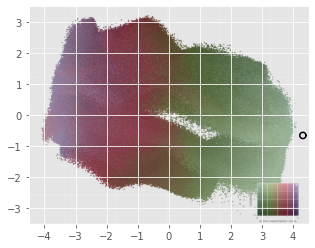

expected_policy = [1.78317837].
confidence = [0.6111624].


In [21]:
cluster.interactive()